# Uploading neccessary Libraries and uploading dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving UK DATA PROJECT copy.xlsx to UK DATA PROJECT copy.xlsx


In [ ]:
import io
df = pd.read_excel(io.BytesIO(uploaded.get('UK DATA PROJECT copy.xlsx')))
df

,Transaction_number,Date,ProductNo,Amount,ProductName,CustomerNo
0,581482,2019-09-12 00:00:00,22485,257.64,Set Of 2 Wooden Market Crates,17490.0
1,581475,2019-09-12 00:00:00,22596,383.4,Christmas Star Wish List Chalkboard,13069.0
2,581475,2019-09-12 00:00:00,23235,138.36,Storage Tin Vintage Leaf,13069.0
3,581475,2019-09-12 00:00:00,23272,127.8,Tree T-Light Holder Willie Winkie,13069.0
4,581475,2019-09-12 00:00:00,23239,71.64,Set Of 4 Knick Knack Tins Poppies,13069.0
...,...,...,...,...,...,...
485090,,2018-01-12 00:00:00,22557,,Plasters In Tin Vintage Paisley,17548.0
485091,,2018-01-12 00:00:00,22553,,Plasters In Tin Skulls,17548.0
485092,,2018-01-12 00:00:00,22960,,Jam Making Set With Jars,17897.0
485093,,2018-01-12 00:00:00,22632,,Hand Warmer Red Retrospot,17841.0


# Data cleaning.

In [ ]:
df.isnull().sum()

Transaction_number     0
Date                   0
ProductNo              0
Amount                 0
ProductName            0
CustomerNo            55
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 5169


In [ ]:
missing_value_ratio = df['CustomerNo'].isnull().sum() / df['CustomerNo'].count() * 100
print('The missing value ratio is %.4f' % missing_value_ratio)

The missing value ratio is 0.0000


In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(479871, 6)

# Data transformation and created features for RFMA (Recency, Frequency, Monetary, Advocacy) Model.

In [ ]:
from datetime import datetime

df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df['ProductNo'] = pd.to_numeric(df['ProductNo'], errors= 'coerce')

In [ ]:
current_date = max(df['Date'])
current_date

Timestamp('2019-12-10 00:00:00')

In [ ]:
min(df['Date'])

Timestamp('2018-01-12 00:00:00')

In [ ]:
df['CustomerNo'] = df['CustomerNo'].astype(str)

In [ ]:
#Calculating recency :: giving Max date of the datasets ad a threshold for whole datasets.

df_recency = df.groupby(by='CustomerNo',
                        as_index=False)['Date'].max()
df_recency.columns = ['CustomerNo', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (current_date - x).days)
df_recency.head()


,CustomerNo,LastPurchaseDate,Recency
0,12004.0,2019-04-26,228
1,12006.0,2019-05-05,219
2,12008.0,2019-08-03,129
3,12013.0,2018-12-15,360
4,12024.0,2019-06-16,177


In [ ]:
#Using Transcation number for frequency because it has each unique records for each visits.
df_frequency = df.groupby('CustomerNo')['Transaction_number'].count()
df_frequency = df_frequency.reset_index()
df_frequency.columns = ['CustomerNo', 'Frequency']
df_frequency.head()

,CustomerNo,Frequency
0,12004.0,56
1,12006.0,1
2,12008.0,203
3,12013.0,1
4,12024.0,5


In [ ]:
#Converting amount into numeric becasue python takes the input value as string and we have amount on float

df['Amount'] = pd.to_numeric(df['Amount'], errors= 'coerce')

In [ ]:
df_monetary= df.groupby(by='CustomerNo', as_index=False)['Amount'].sum()
df_monetary.columns = ['CustomerNo', 'Monetary']
df_monetary.head()

,CustomerNo,Monetary
0,12004.0,1509.60
1,12006.0,24.76
2,12008.0,5689.57
3,12013.0,69.96
4,12024.0,149.52


In [ ]:
#Merging customer Number and frequency
rf_df = df_recency.merge(df_frequency, on='CustomerNo')

In [ ]:
rfm_df = rf_df.merge(df_monetary, on='CustomerNo').drop(
    columns='LastPurchaseDate')
rfm_df.head()

,CustomerNo,Recency,Frequency,Monetary
0,12004.0,228,56,1509.60
1,12006.0,219,1,24.76
2,12008.0,129,203,5689.57
3,12013.0,360,1,69.96
4,12024.0,177,5,149.52


In [ ]:
# Advocacy referes Distinct(Products)
# Calculate the number of unique products purchased by each customer
advocacy_df = df.groupby('CustomerNo')['ProductNo'].nunique().reset_index()
advocacy_df.rename(columns={'ProductNo': 'Advocacy'}, inplace=True)

In [ ]:
rfma = rfm_df.merge(advocacy_df, on='CustomerNo')

In [ ]:
rfma.head()

,CustomerNo,Recency,Frequency,Monetary,Advocacy
0,12004.0,228,56,1509.60,47
1,12006.0,219,1,24.76,1
2,12008.0,129,203,5689.57,167
3,12013.0,360,1,69.96,1
4,12024.0,177,5,149.52,5


In [ ]:
rfma.drop(rfma[rfma['Monetary'] ==0].index, inplace = True)

In [ ]:
rfma.drop(rfma[rfma['Advocacy'] ==0].index, inplace = True)

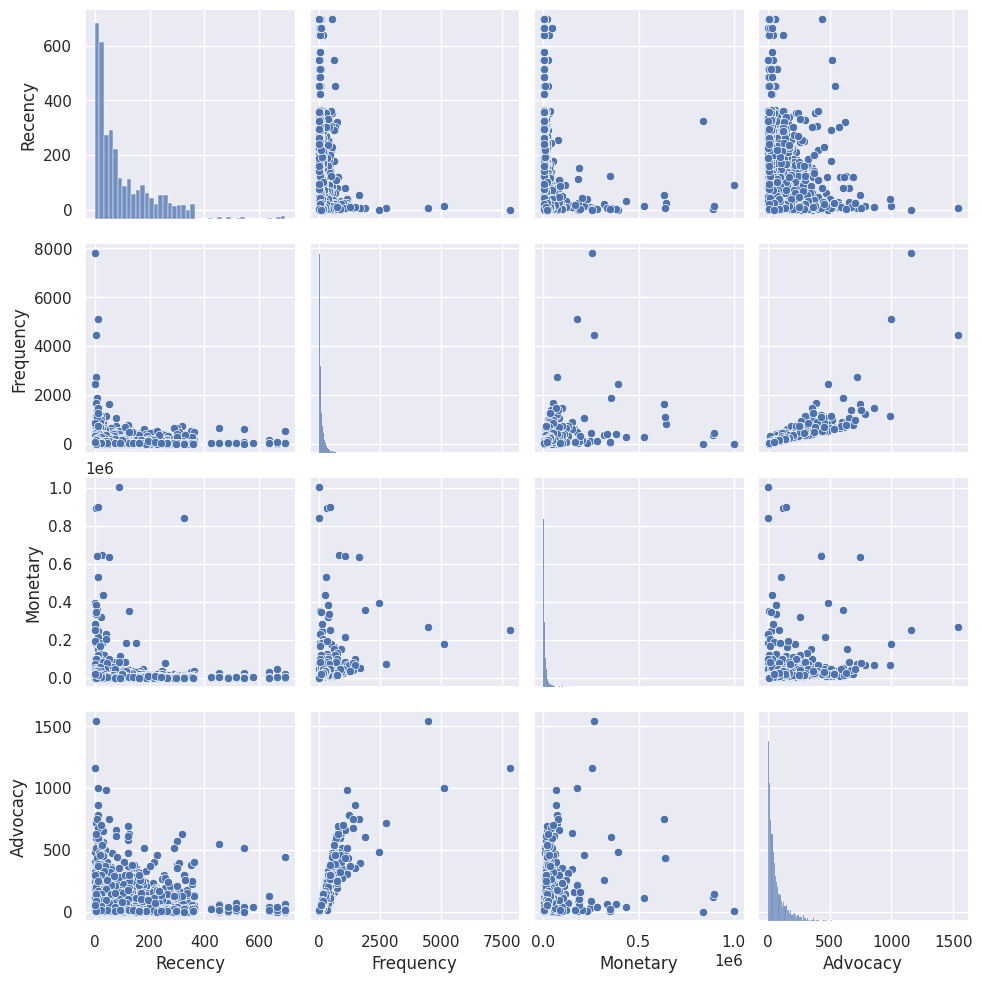

In [ ]:
sns.pairplot(rfma)

In [ ]:
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

Statistics of RFMA, before outliers have been removed.

In [ ]:
# Calculate the minimum, median, and maximum values of Recency, Frequency, and Monetary
rfm_summary = rfma[['Recency', 'Frequency', 'Monetary', 'Advocacy']].describe().transpose()
rfm_summary = rfm_summary[['min', '50%', 'max']]
rfm_summary.columns = ['Minimum', 'Median', 'Maximum']

# Print the summary statistics
print(rfm_summary)
##WIthout EXCLUDING OUTLIERS

           Minimum   Median     Maximum
Recency       0.00    60.00      697.00
Frequency     1.00    51.00     7802.00
Monetary      5.97  4662.76  1002741.57
Advocacy      1.00    40.00     1541.00


In [ ]:
rfma.describe()

,Recency,Frequency,Monetary,Advocacy
count,4280.000000,4280.000000,4.280000e+03,4280.000000
mean,102.628738,112.095093,1.222692e+04,75.060514
std,111.926462,225.271808,4.103473e+04,100.830716
min,0.000000,1.000000,5.970000e+00,1.000000
25%,20.000000,19.000000,1.801725e+03,16.000000
50%,60.000000,51.000000,4.662760e+03,40.000000
75%,157.000000,132.000000,1.154576e+04,94.000000
max,697.000000,7802.000000,1.002742e+06,1541.000000


# Extraction of outliers with IQR method.

In [ ]:
#define a fucniton called box plot,, to find anamolies

def plot_boxplot(cf, ft):
  cf.boxplot(column =[ft])
  plt.grid(False)
  plt.show()

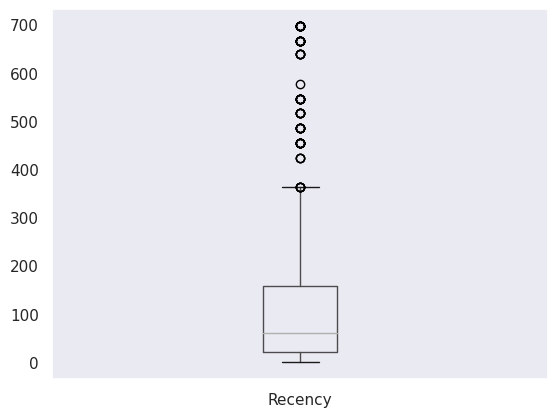

In [ ]:
plot_boxplot(rfma, "Recency")

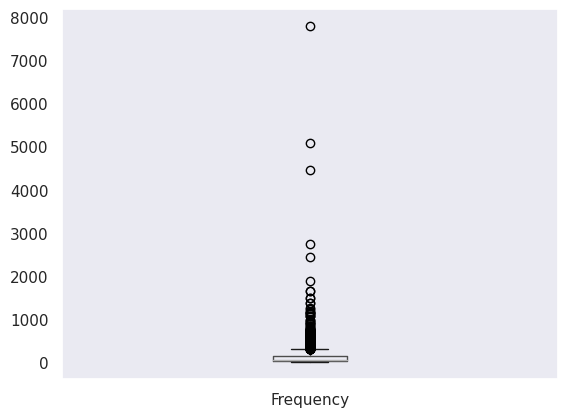

In [ ]:
plot_boxplot(rfma, "Frequency")

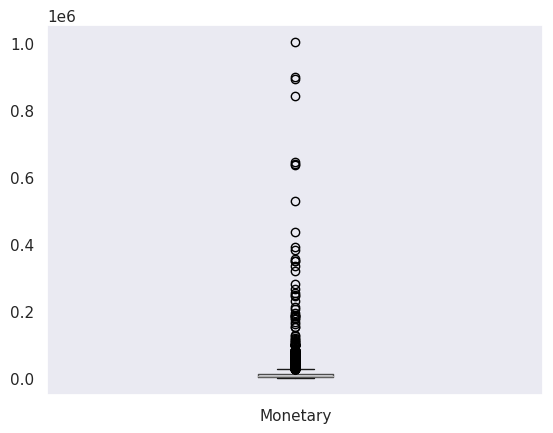

In [ ]:
plot_boxplot(rfma, "Monetary")

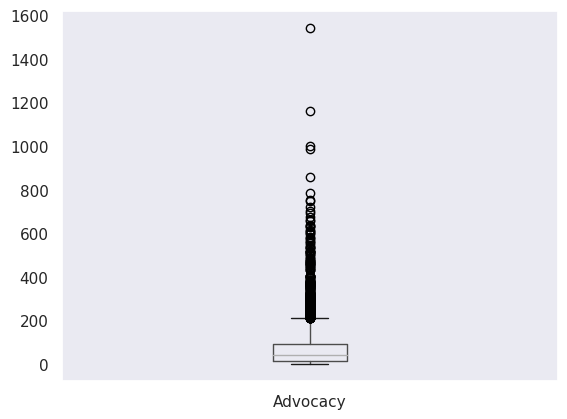

In [ ]:
plot_boxplot(rfma, "Advocacy")

In [ ]:
#Setting a cutoff value for the outliers
def outliers (cf, ft):
  Q1 = cf[ft].quantile(0.25)
  Q3 = cf[ft].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  ls= cf.index [ (cf[ft]  < lower_bound) | (cf[ft] > upper_bound)]

  return ls

In [ ]:
#creating an empty list to store the output

recency_list= []
for feature in ['Recency']:
    recency_list.extend(outliers(rfma, feature))


In [ ]:
#creating an empty list to store the output

frequency_list= []
for feature1 in ['Frequency']:
    frequency_list.extend(outliers(rfma, feature1))


In [ ]:
#creating an empty list to store the output

monetary_list= []
for feature2 in ['Monetary']:
    monetary_list.extend(outliers(rfma, feature2))



In [ ]:
a= []
for feature3 in ['Advocacy']:
    a.extend(outliers(rfma, feature3))


In [ ]:
def remove(cf, ls):
    ls = sorted(set(ls))
    cf = cf.drop(ls)
    return cf

Here, features outliers have been removed and ploted on boxplot to visualize changes.

In [ ]:
cf_cleaned = remove(rfma, recency_list)

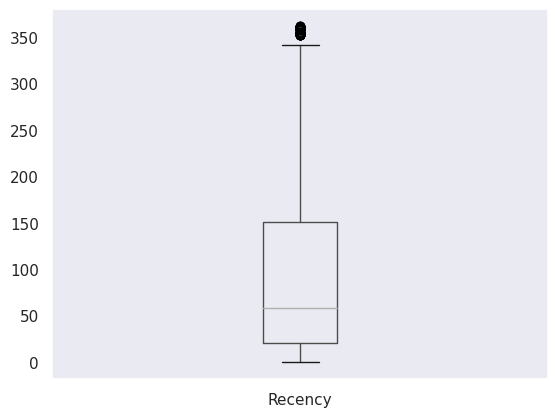

In [ ]:
#CHECKING AFTER DEDUCTING OUTLIERS ::

plot_boxplot(cf_cleaned,'Recency')

In [ ]:
cf_cleaned = remove(rfma, frequency_list)

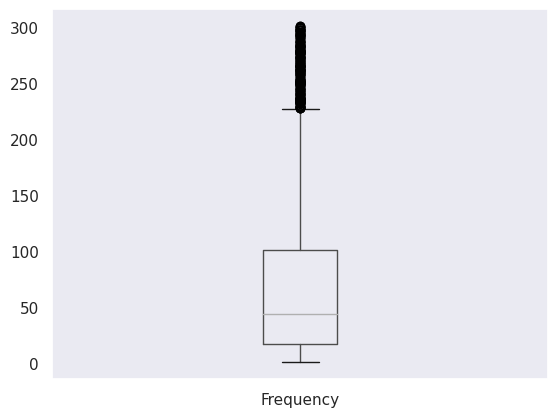

In [ ]:
plot_boxplot(cf_cleaned,'Frequency')

In [ ]:
cf_cleaned = remove(rfma, monetary_list)

#you have to clean cf_clean manually .. to csavce on cf

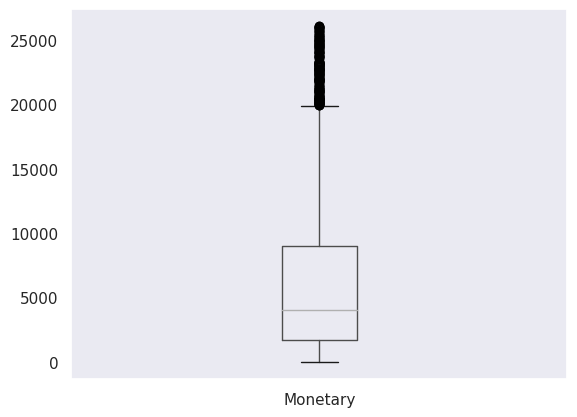

In [ ]:
plot_boxplot(cf_cleaned,'Monetary')

In [ ]:
cf_cleaned = remove(rfma, a)

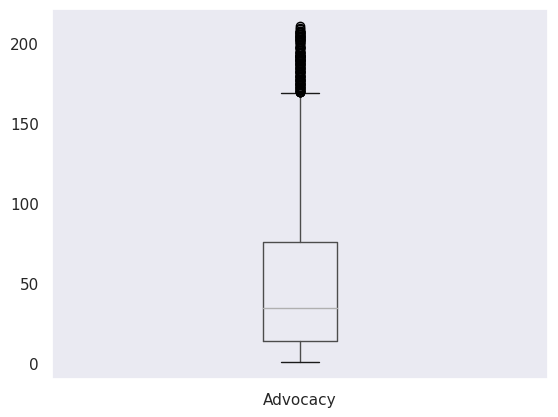

In [ ]:
plot_boxplot(cf_cleaned,'Advocacy')

New dataframe after outliers were removed.

In [ ]:
cf_cleaned

,CustomerNo,Recency,Frequency,Monetary,Advocacy
0,12004.0,228,56,1509.60,47
1,12006.0,219,1,24.76,1
2,12008.0,129,203,5689.57,167
3,12013.0,360,1,69.96,1
4,12024.0,177,5,149.52,5
...,...,...,...,...,...
4318,18278.0,74,9,854.62,9
4319,18280.0,160,10,623.26,10
4320,18281.0,4,7,576.58,7
4321,18282.0,93,13,1044.86,12


[[<Axes: title={'center': 'Recency'}>
  <Axes: title={'center': 'Frequency'}>]
 [<Axes: title={'center': 'Monetary'}>
  <Axes: title={'center': 'Advocacy'}>]]


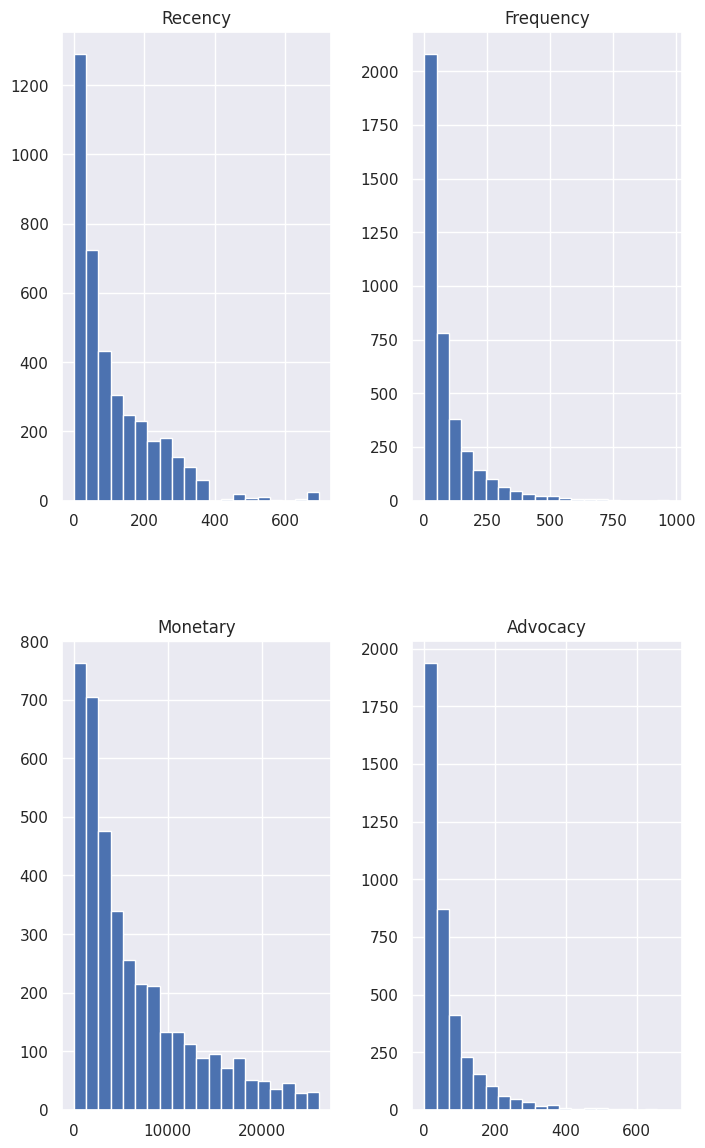

In [ ]:
print(cf_cleaned.hist(figsize=(8, 14), bins=20))

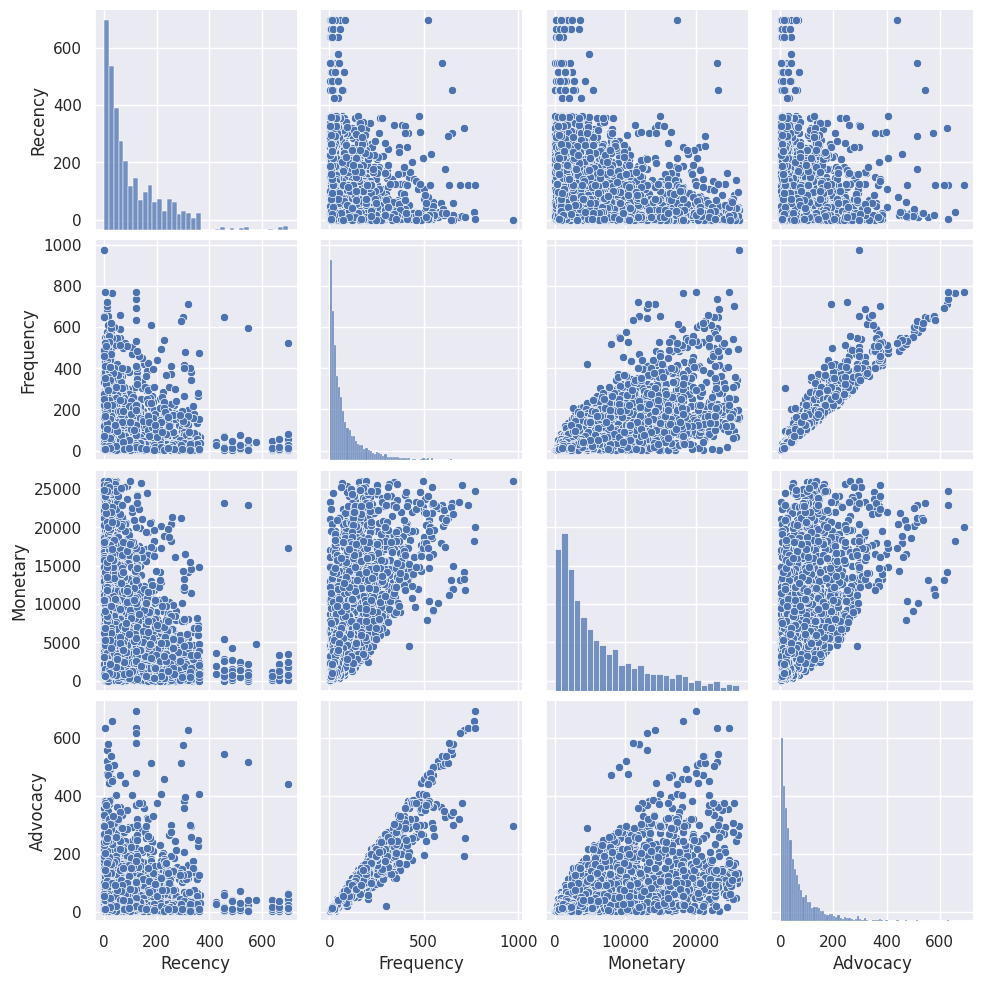

In [ ]:
sns.pairplot(cf_cleaned)

Statistics after anamolies was removed.

In [ ]:
# Calculate the minimum, median, and maximum values of Recency, Frequency, and Monetary
rfm_summary2 = cf_cleaned[['Recency', 'Frequency', 'Monetary', 'Advocacy']].describe().transpose()
rfm_summary2 = rfm_summary2[['min', '50%', 'max']]
rfm_summary2.columns = ['Minimum', 'Median', 'Maximum']

# Print the summary statistics after removing outliers
print(rfm_summary2)
#Those are converted on to days, where

           Minimum   Median     Maximum
Recency       0.00    64.00      697.00
Frequency     1.00    45.00      712.00
Monetary      5.97  4058.54  1002741.57
Advocacy      1.00    35.00      211.00


# Applied K-means Algorithm for segmentation of RFMA.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


Checked for optimal number of clusters.

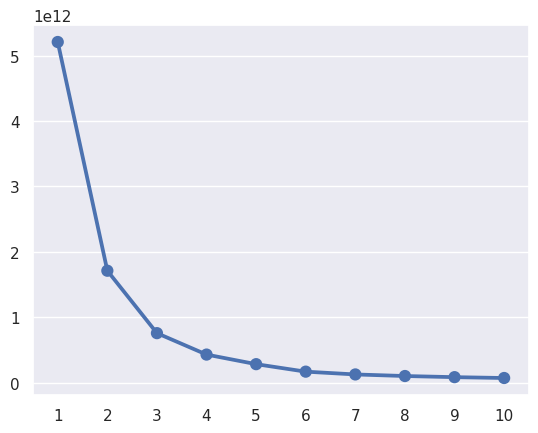

In [ ]:
SSE = [ ]
for k in range(0, 10):
  kmeans = KMeans(n_clusters=k+1, random_state=0).fit(cf_cleaned)
  SSE.append(kmeans.inertia_)

sns.pointplot(x=list(range (1,11)), y=SSE)
plt.show()


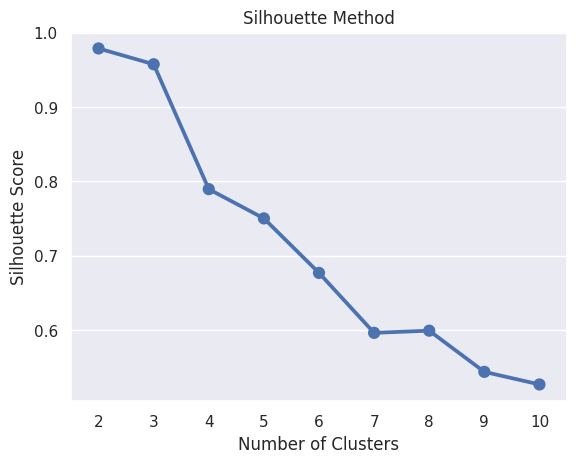

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(cf_cleaned)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(cf_cleaned, labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
sns.pointplot(x=list(range(2, 11)), y=silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

**Also, can you show one statistics of choosing 5 clusters to show a difference between them and why you chose to go with 4, because in 5, 2 of them was similar,**
\

In [ ]:
k= 4
kmeans = KMeans(n_clusters=k, random_state=0).fit(cf_cleaned)
cf_cleaned['Cluster'] = kmeans.labels_


Each statistics of clusters.

In [ ]:
cluster_summary = cf_cleaned.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Advocacy': 'mean',
    'CustomerNo': 'count',
})
print(cluster_summary)

            Recency   Frequency       Monetary    Advocacy  CustomerNo
Cluster                                                               
0         37.955102  201.065306   43310.635429  107.604082         245
1        107.500000  194.000000  907765.565000   68.250000           4
2         32.722222  202.333333  269573.292778   60.666667          18
3        111.208435   64.514830    5535.068767   48.546939        3675


In [ ]:
# Iterate over each cluster
#use this to get each cluster summary , however you might need to add some thingsL
for i in range(k):
    # Create a subset of the data for the current cluster
    cluster_data = cf_cleaned[cf_cleaned['Cluster'] == i]

    # Calculate the minimum, median, and maximum values of Recency, Frequency, and Monetary for the current cluster
    a = cluster_data[['Recency', 'Frequency', 'Monetary', 'Advocacy']].describe().transpose()[['min', '50%', 'max']]

    # Print the summary statistics for the current cluster
    print(f"Cluster {i} Summary:")
    print(a)
    print("\n")

Cluster 0 Summary:
               min     50%      max
Recency       0.00    54.0   577.00
Frequency     1.00    67.0   551.00
Monetary   4191.06  6389.9  9724.29
Advocacy      1.00    54.0   499.00


Cluster 1 Summary:
               min      50%      max
Recency       0.00     32.0    362.0
Frequency     1.00    120.0    720.0
Monetary   9748.86  12574.4  16763.2
Advocacy      1.00     91.0    627.0


Cluster 2 Summary:
            min       50%      max
Recency    0.00   118.000   697.00
Frequency  1.00    20.000   213.00
Monetary   5.97  1710.625  4215.73
Advocacy   1.00    17.000   173.00


Cluster 3 Summary:
                min      50%       max
Recency        0.00     25.0    697.00
Frequency      2.00    186.5    973.00
Monetary   16866.39  20216.2  26096.45
Advocacy       1.00    126.0    692.00




In [ ]:
cf_cleaned

,CustomerNo,Recency,Frequency,Monetary,Advocacy,Cluster
0,12004.0,228,56,1509.60,47,2
1,12006.0,219,1,24.76,1,2
2,12008.0,129,203,5689.57,167,0
3,12013.0,360,1,69.96,1,2
4,12024.0,177,5,149.52,5,2
...,...,...,...,...,...,...
4319,18280.0,160,10,623.26,10,2
4320,18281.0,4,7,576.58,7,2
4321,18282.0,93,13,1044.86,12,2
4322,18283.0,10,720,11773.90,252,1





# Visualization of Clusters.

In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter_3d(cf_cleaned, x='Recency', y='Frequency', z='Monetary',
                    color='Cluster',
                    width=900, height=700)

# Set the axis titles
fig.update_layout(scene=dict(xaxis_title='Recency',
                             yaxis_title='Frequency',
                             zaxis_title='Monetary'))

# Show the plot
fig.show()


Customer from each clusters and their contribution.

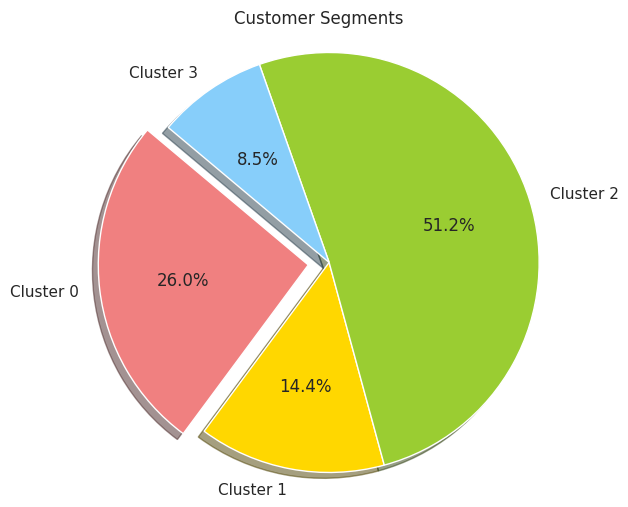

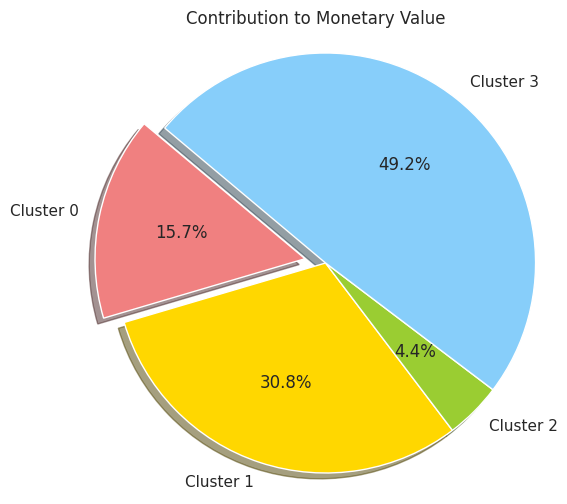

In [ ]:
#for providing pie chart which I havent checkeed

import matplotlib.pyplot as plt

# Pie chart for customer segment
plt.figure(figsize=(6,6))
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
sizes = cluster_summary['CustomerNo']
colors = ['lightcoral', 'gold', 'yellowgreen', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Customer Segments')

# Pie chart for monetary value
plt.figure(figsize=(6,6))
sizes = cluster_summary['Monetary']
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Contribution to Monetary Value')

plt.show()

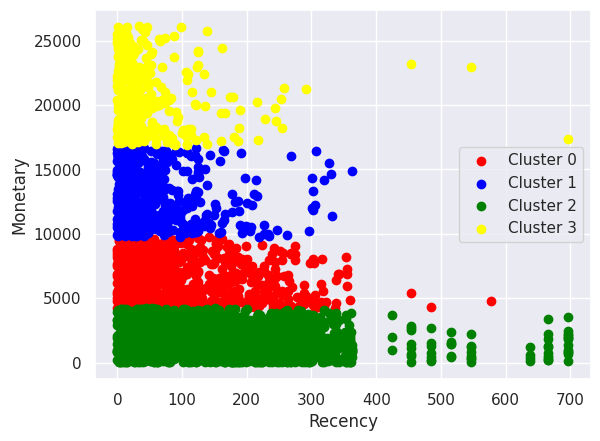

In [ ]:
# Plot each cluster individually
# Visualize clusters on a scatter plot
colors = ['red', 'blue', 'green', 'yellow']
fig, ax = plt.subplots()
for i in range(len(colors)):
    cluster = cf_cleaned[cf_cleaned['Cluster'] == i]
    ax.scatter(cluster['Recency'], cluster['Monetary'], c=colors[i], label=f'Cluster {i}')
ax.legend()
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
plt.show()

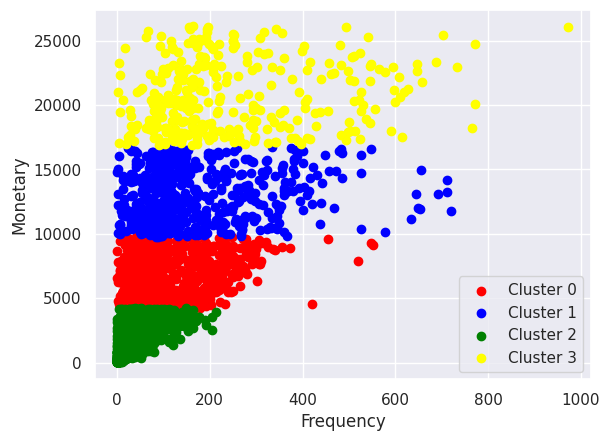

In [ ]:
# Plot each cluster individually
# Visualize clusters on a scatter plot
colors = ['red', 'blue', 'green', 'yellow']
fig, ax = plt.subplots()
for i in range(len(colors)):
    cluster = cf_cleaned[cf_cleaned['Cluster'] == i]
    ax.scatter(cluster['Frequency'], cluster['Monetary'], c=colors[i], label=f'Cluster {i}')
ax.legend()
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
plt.show()

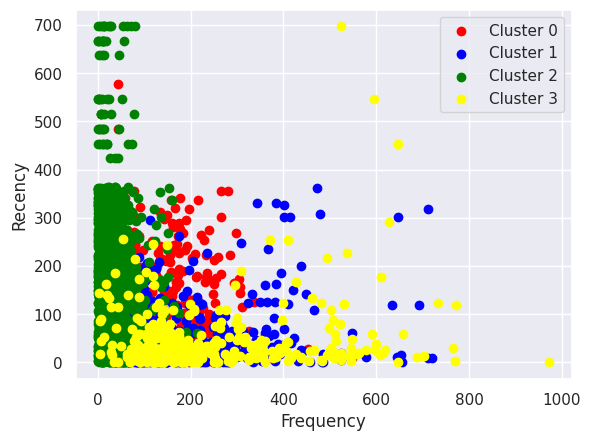

In [ ]:
# Plot each cluster individually
# Visualize clusters on a scatter plot
colors = ['red', 'blue', 'green','yellow']
fig, ax = plt.subplots()
for i in range(len(colors)):
    cluster = cf_cleaned[cf_cleaned['Cluster'] == i]
    ax.scatter(cluster['Frequency'], cluster['Recency'], c=colors[i], label=f'Cluster {i}')
ax.legend()
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
plt.show()

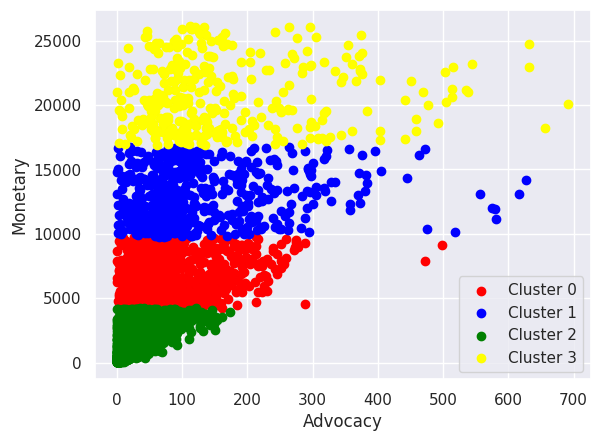

In [ ]:
# Plot each cluster individually
# Visualize clusters on a scatter plot
colors = ['red', 'blue', 'green','yellow']
fig, ax = plt.subplots()
for i in range(len(colors)):
    cluster = cf_cleaned[cf_cleaned['Cluster'] == i]
    ax.scatter(cluster['Advocacy'], cluster['Monetary'], c=colors[i], label=f'Cluster {i}')
ax.legend()
ax.set_xlabel('Advocacy')
ax.set_ylabel('Monetary')
plt.show()

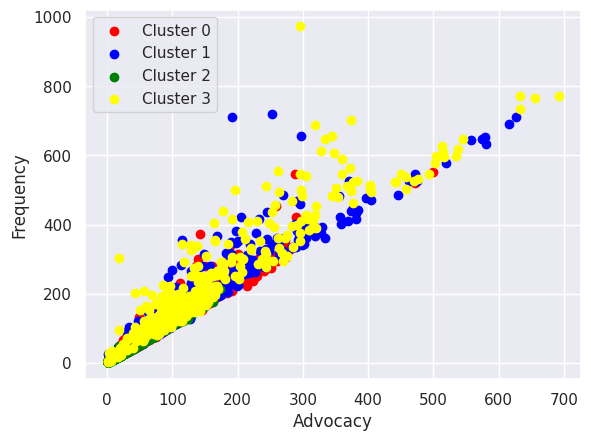

In [ ]:
# Plot each cluster individually
# Visualize clusters on a scatter plot
colors = ['red', 'blue', 'green','yellow']
fig, ax = plt.subplots()
for i in range(len(colors)):
    cluster = cf_cleaned[cf_cleaned['Cluster'] == i]
    ax.scatter(cluster['Advocacy'], cluster['Frequency'], c=colors[i], label=f'Cluster {i}')
ax.legend()
ax.set_xlabel('Advocacy')
ax.set_ylabel('Frequency')
plt.show()

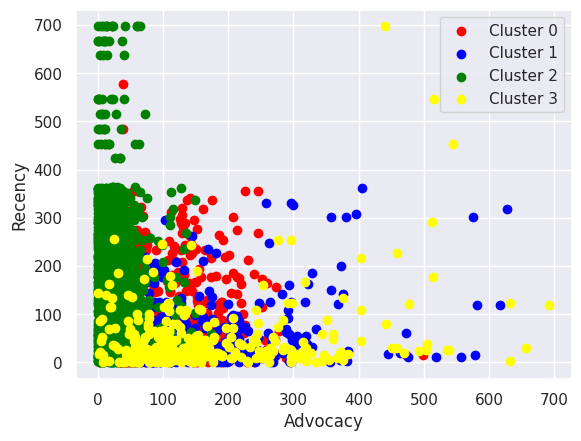

In [ ]:
# Plot each cluster individually
# Visualize clusters on a scatter plot
colors = ['red', 'blue', 'green','yellow']
fig, ax = plt.subplots()
for i in range(len(colors)):
    cluster = cf_cleaned[cf_cleaned['Cluster'] == i]
    ax.scatter(cluster['Advocacy'], cluster['Recency'], c=colors[i], label=f'Cluster {i}')
ax.legend()
ax.set_xlabel('Advocacy')
ax.set_ylabel('Recency')
plt.show()

# Extracted which products being used by each clusters.

In [ ]:
#checking clusters
cluster2= cf_cleaned.loc[cf_cleaned['Cluster'] == 2]

cluster0= cf_cleaned.loc[cf_cleaned['Cluster'] == 0]

cluster1= cf_cleaned.loc[cf_cleaned['Cluster'] == 1]

cluster3= cf_cleaned.loc[cf_cleaned['Cluster'] == 3]

In [ ]:
cluster0.describe()

,Recency,Frequency,Monetary,Advocacy,Cluster
count,1020.000000,1020.000000,1020.000000,1020.000000,1020.0
mean,83.404902,96.489216,6577.282059,75.405882,0.0
std,83.119230,77.689733,1591.390046,60.664589,0.0
min,0.000000,1.000000,4191.060000,1.000000,0.0
25%,22.000000,44.000000,5141.655000,35.000000,0.0
50%,54.000000,67.000000,6389.900000,54.000000,0.0
75%,117.000000,134.000000,7968.837500,102.000000,0.0
max,577.000000,551.000000,9724.290000,499.000000,0.0


First, inidvidual customer number has to be find out because in RFMA model, each customer is categorised as a total for his entire lifetime, where single customer have purchased multiple orders. so, In order to find out their multiple purchase and comparing those products. to find out each clusters products name with highes 10 products.

In [ ]:
#getting customer numbers for each clusters

cluster1_customers = cluster1['CustomerNo'].unique()
cluster2_customers = cluster2['CustomerNo'].unique()
cluster3_customers = cluster3['CustomerNo'].unique()
cluster0_customers = cluster0['CustomerNo'].unique()


In [ ]:
cluster0_customers.shape

(1020,)

In [ ]:
cluster1_product_data = df[df['CustomerNo'].isin(cluster1_customers)]
cluster2_product_data = df[df['CustomerNo'].isin(cluster2_customers)]
cluster3_product_data = df[df['CustomerNo'].isin(cluster3_customers)]
cluster0_product_data = df[df['CustomerNo'].isin(cluster0_customers)]

In [ ]:
cluster0_product_data

,Transaction_number,Date,ProductNo,Amount,ProductName,CustomerNo
49,581480,2019-09-12,23464.0,61.28,Vintage Zinc Watering Can Small,14441.0
50,581480,2019-09-12,22411.0,123.80,Jumbo Shopper Vintage Red Paisley,14441.0
51,581480,2019-09-12,NaN,116.88,Red Woolly Hottie White Heart,14441.0
52,581480,2019-09-12,22633.0,148.80,Hand Warmer Union Jack,14441.0
53,581480,2019-09-12,23355.0,183.84,Hot Water Bottle Keep Calm,14441.0
...,...,...,...,...,...,...
485065,536528,2018-01-12,22635.0,20.45,Childs Breakfast Set Dolly Girl,15525.0
485066,536528,2018-01-12,22634.0,20.45,Childs Breakfast Set Spaceboy,15525.0
485067,536528,2018-01-12,22968.0,61.35,Rose Cottage Keepsake Box,15525.0
485068,536529,2018-01-12,22487.0,40.90,White Wood Garden Plant Ladder,14237.0


In [ ]:
cluster1_merged = pd.merge(cluster1, cluster1_product_data[['CustomerNo', 'ProductName']], on='CustomerNo')
cluster2_merged = pd.merge(cluster2, cluster2_product_data[['CustomerNo', 'ProductName']], on='CustomerNo')
cluster3_merged = pd.merge(cluster3, cluster3_product_data[['CustomerNo', 'ProductName']], on='CustomerNo')
cluster0_merged = pd.merge(cluster0, cluster0_product_data[['CustomerNo', 'ProductName']], on='CustomerNo')

In [ ]:
cluster0_merged.describe()


,Recency,Frequency,Monetary,Advocacy,Cluster
count,98419.000000,98419.000000,98419.000000,98419.000000,98419.0
mean,83.544102,158.980939,6919.146743,122.644357,0.0
std,84.315802,100.249469,1615.496301,78.009285,0.0
min,0.000000,1.000000,4191.060000,1.000000,0.0
25%,19.000000,73.000000,5499.710000,58.000000,0.0
50%,52.000000,150.000000,6902.640000,114.000000,0.0
75%,123.000000,223.000000,8409.510000,168.000000,0.0
max,577.000000,551.000000,9724.290000,499.000000,0.0


In [ ]:
cluster1_products = cluster1_merged['ProductName'].unique()
cluster2_products = cluster2_merged['ProductName'].unique()
cluster3_products = cluster3_merged['ProductName'].unique()
cluster0_products = cluster0_merged['ProductName'].unique()


In [ ]:
cluster0_products.shape

(3434,)

In [ ]:
# Print the unique products for each cluster
print("Cluster 1 Products:", cluster1_products)
print("Cluster 2 Products:", cluster2_products)
print("Cluster 3 Products:", cluster3_products)
print("Cluster 0 Products:", cluster0_products)

Cluster 1 Products: ['Regency Cakestand 3 Tier' 'Landmark Frame Camden Town'
 'Landmark Frame Baker Street' ... 'Polyester Filler Pad 30cmx30cm'
 '12 Pink Hen+Chicks In Basket' 'Pink Goose Feather Tree 60cm']
Cluster 2 Products: ['Red Retrospot Cake Stand' 'Picnic Basket Wicker Large'
 '3 Hook Photo Shelf Antique White' ... 'Enamel Blue Rim Tea Container'
 'Gingham Oven Glove Red Heart' 'Classical Rose Table Lamp']
Cluster 3 Products: ['Chalkboard Kitchen Organiser' 'Cream Sweetheart Mini Chest'
 'Victorian Sewing Box Large' ... 'Black Drop Crystal Necklace'
 'Midnight Blue Drop Crystal Necklace' 'T-Light Holder Silver Petit Four']
Cluster 0 Products: ['Cream Sweetheart Mini Chest' 'Pink Polkadot Garden Parasol'
 'Red Retrospot Cake Stand' ... '60 Gold And Silver Fairy Cake Cases'
 'Scallop Shell Soap Dish' 'Pink/White Christmas Tree 30cm']


In [ ]:
data_1 = {
    'Cluster': ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 0'],
    'Products': [list(cluster1_products), list(cluster2_products), list(cluster3_products), list(cluster0_products)]
}

aab = pd.DataFrame(data_1)

# Display the dataframe
print(aab)

     Cluster                                           Products
0  Cluster 1  [Regency Cakestand 3 Tier, Landmark Frame Camd...
1  Cluster 2  [Red Retrospot Cake Stand, Picnic Basket Wicke...
2  Cluster 3  [Chalkboard Kitchen Organiser, Cream Sweethear...
3  Cluster 0  [Cream Sweetheart Mini Chest, Pink Polkadot Ga...


In [ ]:
# Define a function to get the top N products for a given cluster
def get_top_products(cluster_products, n=10):
    unique_products, product_counts = np.unique(cluster_products, return_counts=True)
    sorted_indices = np.argsort(product_counts)[::-1]
    top_indices = sorted_indices[:n]
    top_products = unique_products[top_indices]
    return top_products

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.update_layout(title_text="Top 10 Products for Each Cluster")

# Add a bar trace for each cluster
fig.add_trace(go.Bar(
    x=["Cluster 1"],
    y=[len(cluster1_products)],
    name="Cluster 1",
    marker_color="blue"
))

fig.add_trace(go.Bar(
    x=["Cluster 2"],
    y=[len(cluster2_products)],
    name="Cluster 2",
    marker_color="green"
))

fig.add_trace(go.Bar(
    x=["Cluster 3"],
    y=[len(cluster3_products)],
    name="Cluster 3",
    marker_color="orange"
))

fig.add_trace(go.Bar(
    x=["Cluster 0"],
    y=[len(cluster0_products)],
    name="Cluster 0",
    marker_color="purple"
))

# Add annotations for each cluster
fig.update_layout(annotations=[
    go.layout.Annotation(
        x="Cluster 1",
        y=len(cluster1_products),
        text="<br>".join(get_top_products(cluster1_products, n=10)),
        showarrow=False,
        font=dict(color="black")
    ),
    go.layout.Annotation(
        x="Cluster 2",
        y=len(cluster2_products),
        text="<br>".join(get_top_products(cluster2_products, n=10)),
        showarrow=False,
        font=dict(color="black")
    ),
    go.layout.Annotation(
        x="Cluster 3",
        y=len(cluster3_products),
        text="<br>".join(get_top_products(cluster3_products, n=10)),
        showarrow=False,
        font=dict(color="black")
    ),
    go.layout.Annotation(
        x="Cluster 0",
        y=len(cluster0_products),
        text="<br>".join(get_top_products(cluster0_products, n=10)),
        showarrow=False,
        font=dict(color="black")
    )
])

# Update the layout
fig.update_layout(
    xaxis_title="Clusters",
    yaxis_title="Number of Unique Products"
)

# Show the interactive graph
fig.show()

# To find out yearly Revenue.

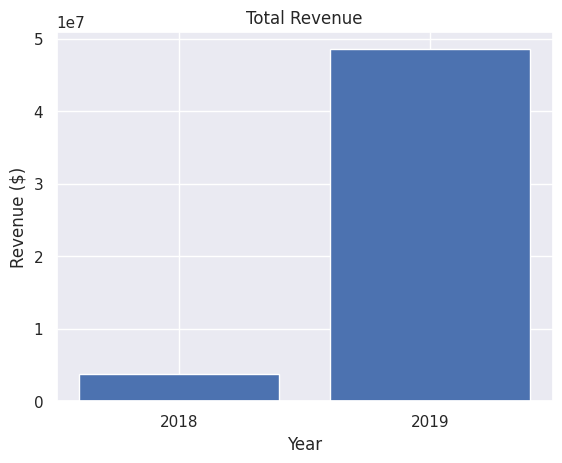

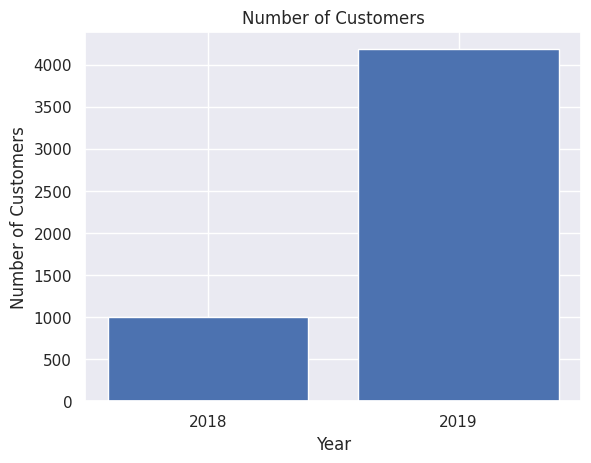

In [ ]:

# Filter data for 2018
start_date_2018 = '2018-01-01'
end_date_2018 = '2018-12-31'
df_2018 = df.loc[(df['Date'] >= start_date_2018) & (df['Date'] <= end_date_2018)]

# Filter data for 2019
start_date_2019 = '2019-01-01'
end_date_2019 = '2019-12-31'
df_2019 = df.loc[(df['Date'] >= start_date_2019) & (df['Date'] <= end_date_2019)]

# Aggregate data for 2018
revenue_2018 = df_2018['Amount'].sum()
customers_2018 = df_2018['CustomerNo'].nunique()

# Aggregate data for 2019
revenue_2019 = df_2019['Amount'].sum()
customers_2019 = df_2019['CustomerNo'].nunique()

# Create a bar graph for revenue
revenue_data = [revenue_2018, revenue_2019]
revenue_years = ['2018', '2019']
plt.bar(revenue_years, revenue_data)
plt.title('Total Revenue')
plt.xlabel('Year')
plt.ylabel('Revenue ($)')
plt.show()

# Create a bar graph for number of customers
customers_data = [customers_2018, customers_2019]
customers_years = ['2018', '2019']
plt.bar(customers_years, customers_data)
plt.title('Number of Customers')
plt.xlabel('Year')
plt.ylabel('Number of Customers')
plt.show()


In [ ]:
df_2018['Amount'].sum()


3796412.29

In [ ]:
cf_cleaned['Monetary'].max()

26096.45



# To find out, top 20 sale products and 5 least products.

In [ ]:

# Count the number of transactions for each product
product_counts = df.groupby('ProductName')['Transaction_number'].nunique()

# Sort the products by number of transactions
least_sold_products = product_counts.sort_values()

# Print the least sold products
print(least_sold_products.head())

ProductName
Antique Lily Fairy Lights            1
Baroque Butterfly Earrings Red       1
Ruby Glass Necklace 42"              1
Light Decoration Battery Operated    1
Wrap Blue Russian Folkart            1
Name: Transaction_number, dtype: int64


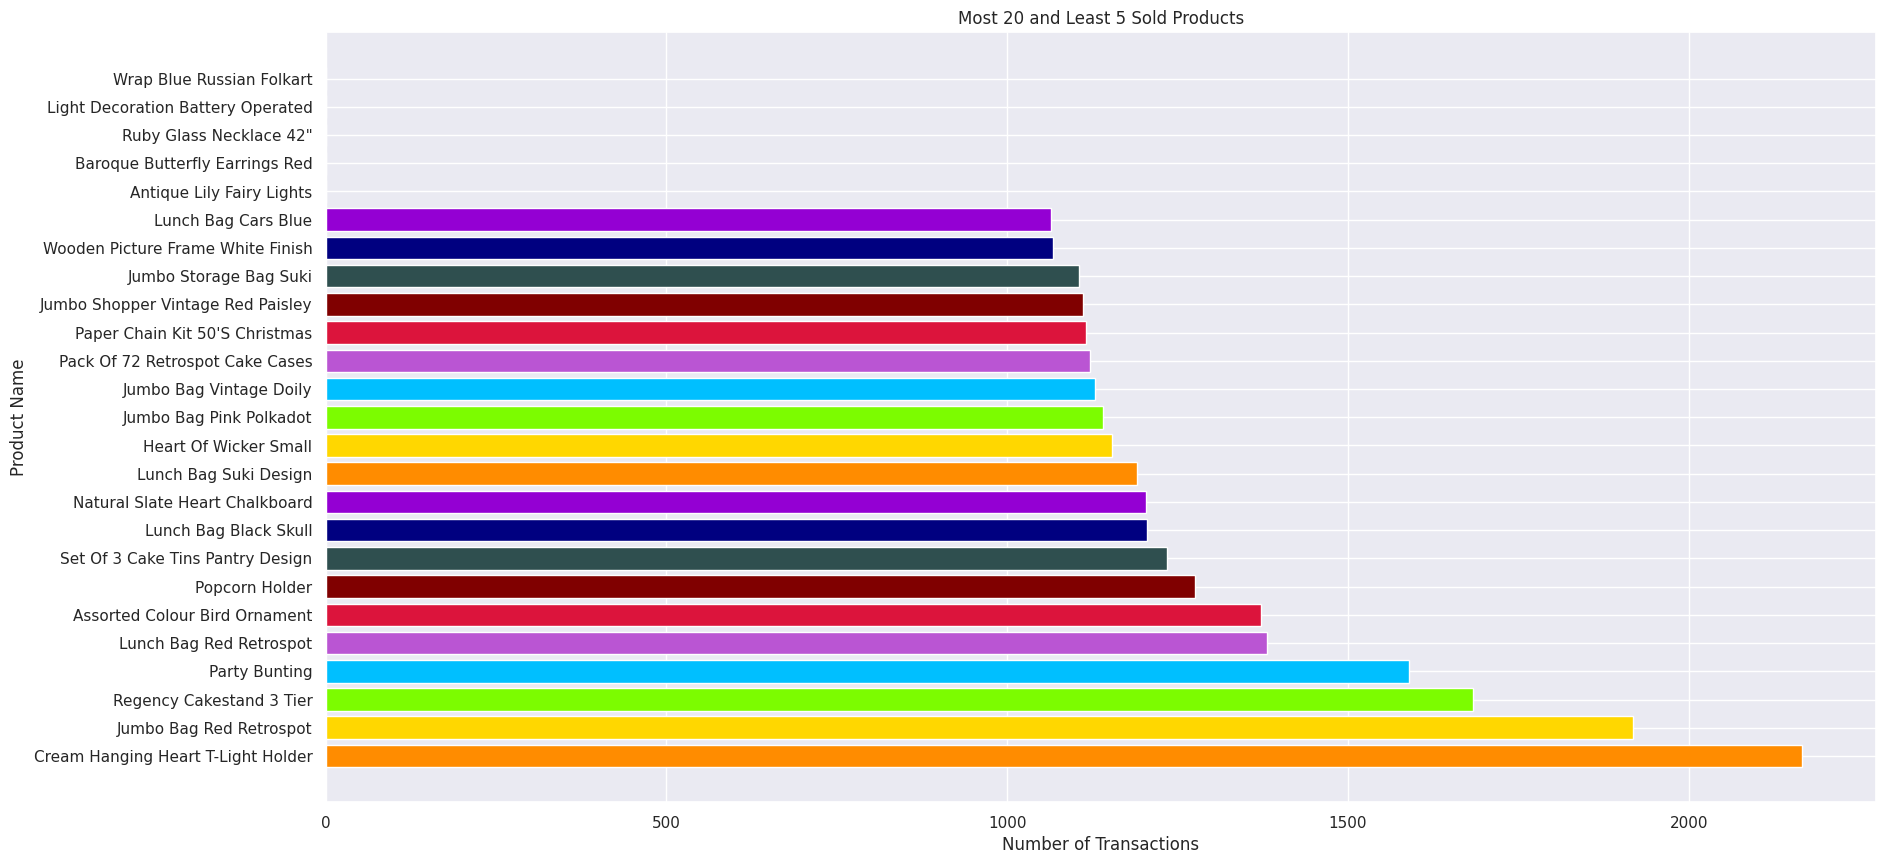

In [ ]:
# Sort the products by number of transactions in descending order
most_sold_products = product_counts.sort_values(ascending=False)

# Get the top 20 most sold products
top20_most_sold_products = most_sold_products.head(20)

# Get the top 5 least sold products
top5_least_sold_products = least_sold_products.head(5)

# Combine the two lists
products = pd.concat([top20_most_sold_products, top5_least_sold_products])

# Combine the two lists
products = pd.concat([top20_most_sold_products, top5_least_sold_products])

# Define colors for the bars
colors = ['darkorange', 'gold', 'lawngreen', 'deepskyblue', 'mediumorchid',
          'crimson', 'maroon', 'darkslategray', 'navy', 'darkviolet']

# Create a horizontal bar graph with different colors for the top 5 most sold products and the top 5 least sold products
# Set the size of the figure
plt.figure(figsize=(20, 10))

plt.barh(top20_most_sold_products.index, top20_most_sold_products.values, color=colors[:20])
plt.barh(top5_least_sold_products.index, top5_least_sold_products.values, color=colors[-5:])
plt.title('Most 20 and Least 5 Sold Products')
plt.xlabel('Number of Transactions')
plt.ylabel('Product Name')
plt.show()

# Cohort Analysis, to find out customer retention and check any missing records.

In [ ]:
# Convert the 'Date' column to a datetime object and extract the month
df['month'] = pd.to_datetime(df['Date']).dt.month

# Get the top 5 products sold for each month
top_products_by_month = df.groupby(['month', 'ProductName'])['Transaction_number'].count().reset_index(name='count').sort_values(['month', 'count'], ascending=[True, False]).groupby('month').head(5)

# Create a bar plot for each month
for month in range(1, 13):
    plt.figure(figsize=(8, 6))
    data = top_products_by_month[top_products_by_month['month'] == month]
    plt.bar(data['ProductName'], data['count'], color='b')
    plt.title(f'Top Products Sold in Month {month}')
    plt.xlabel('Product Name')
    plt.xticks(rotation=90)
    plt.ylabel('Number of Transactions')
    plt.show()

In [ ]:
n_orders = df.groupby(['CustomerNo'])['Transaction_number'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['CustomerNo'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

69.94% of customers ordered more than once.


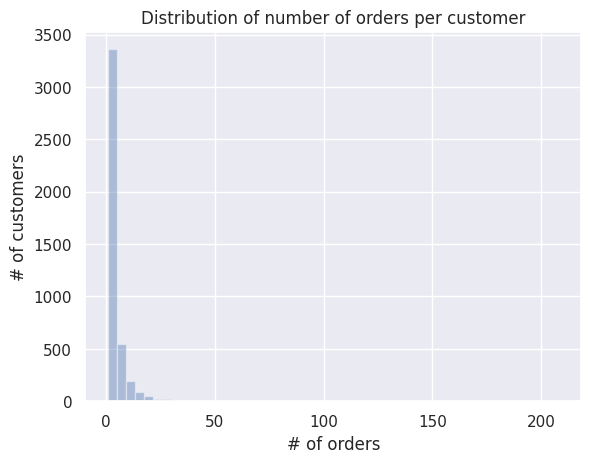

In [ ]:
ax = sns.distplot(n_orders, kde=False, hist=True, bins = 50)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders',
       ylabel='# of customers');

In [ ]:
df['order_month'] = df['Date'].dt.to_period('M')


In [ ]:
df['cohort'] = df.groupby('CustomerNo')['Date'].transform('min').dt.to_period('M')

In [ ]:
df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('CustomerNo', 'nunique')).reset_index(drop=False)

In [ ]:
from operator import attrgetter

In [ ]:
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [ ]:
df_cohort

,cohort,order_month,n_customers,period_number
0,2018-01,2018-01,96,0
1,2018-01,2018-02,8,1
2,2018-01,2018-03,4,2
3,2018-01,2018-05,5,4
4,2018-01,2018-06,6,5
...,...,...,...,...
246,2019-10,2019-11,47,1
247,2019-10,2019-12,7,2
248,2019-11,2019-11,186,0
249,2019-11,2019-12,7,1


In [ ]:
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')

In [ ]:
cohort_pivot


period_number,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cohort,,,,,,,,,,,,,,,,,,,,,
2018-01,96.0,8.0,4.0,NaN,5.0,6.0,4.0,10.0,8.0,4.0,...,34.0,38.0,32.0,39.0,36.0,34.0,38.0,40.0,38.0,19.0
2018-02,109.0,1.0,NaN,NaN,3.0,7.0,5.0,12.0,4.0,NaN,...,39.0,40.0,42.0,49.0,32.0,41.0,45.0,54.0,18.0,NaN
2018-03,49.0,NaN,1.0,1.0,1.0,2.0,3.0,NaN,NaN,12.0,...,20.0,16.0,18.0,17.0,12.0,26.0,24.0,7.0,NaN,NaN
2018-05,65.0,3.0,1.0,1.0,4.0,1.0,NaN,25.0,32.0,22.0,...,28.0,32.0,31.0,33.0,39.0,21.0,NaN,NaN,NaN,NaN
2018-06,81.0,2.0,4.0,4.0,1.0,NaN,28.0,28.0,26.0,23.0,...,27.0,33.0,26.0,39.0,4.0,NaN,NaN,NaN,NaN,NaN
2018-07,60.0,1.0,2.0,1.0,NaN,9.0,21.0,22.0,20.0,19.0,...,21.0,20.0,30.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-08,87.0,3.0,2.0,NaN,29.0,38.0,28.0,34.0,34.0,36.0,...,43.0,49.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09,82.0,2.0,NaN,19.0,30.0,19.0,30.0,23.0,27.0,26.0,...,28.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10,40.0,NaN,11.0,14.0,14.0,15.0,17.0,8.0,13.0,10.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cohort_size = cohort_pivot.iloc[:, 0]

In [ ]:
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [ ]:
import matplotlib.colors as mcolors

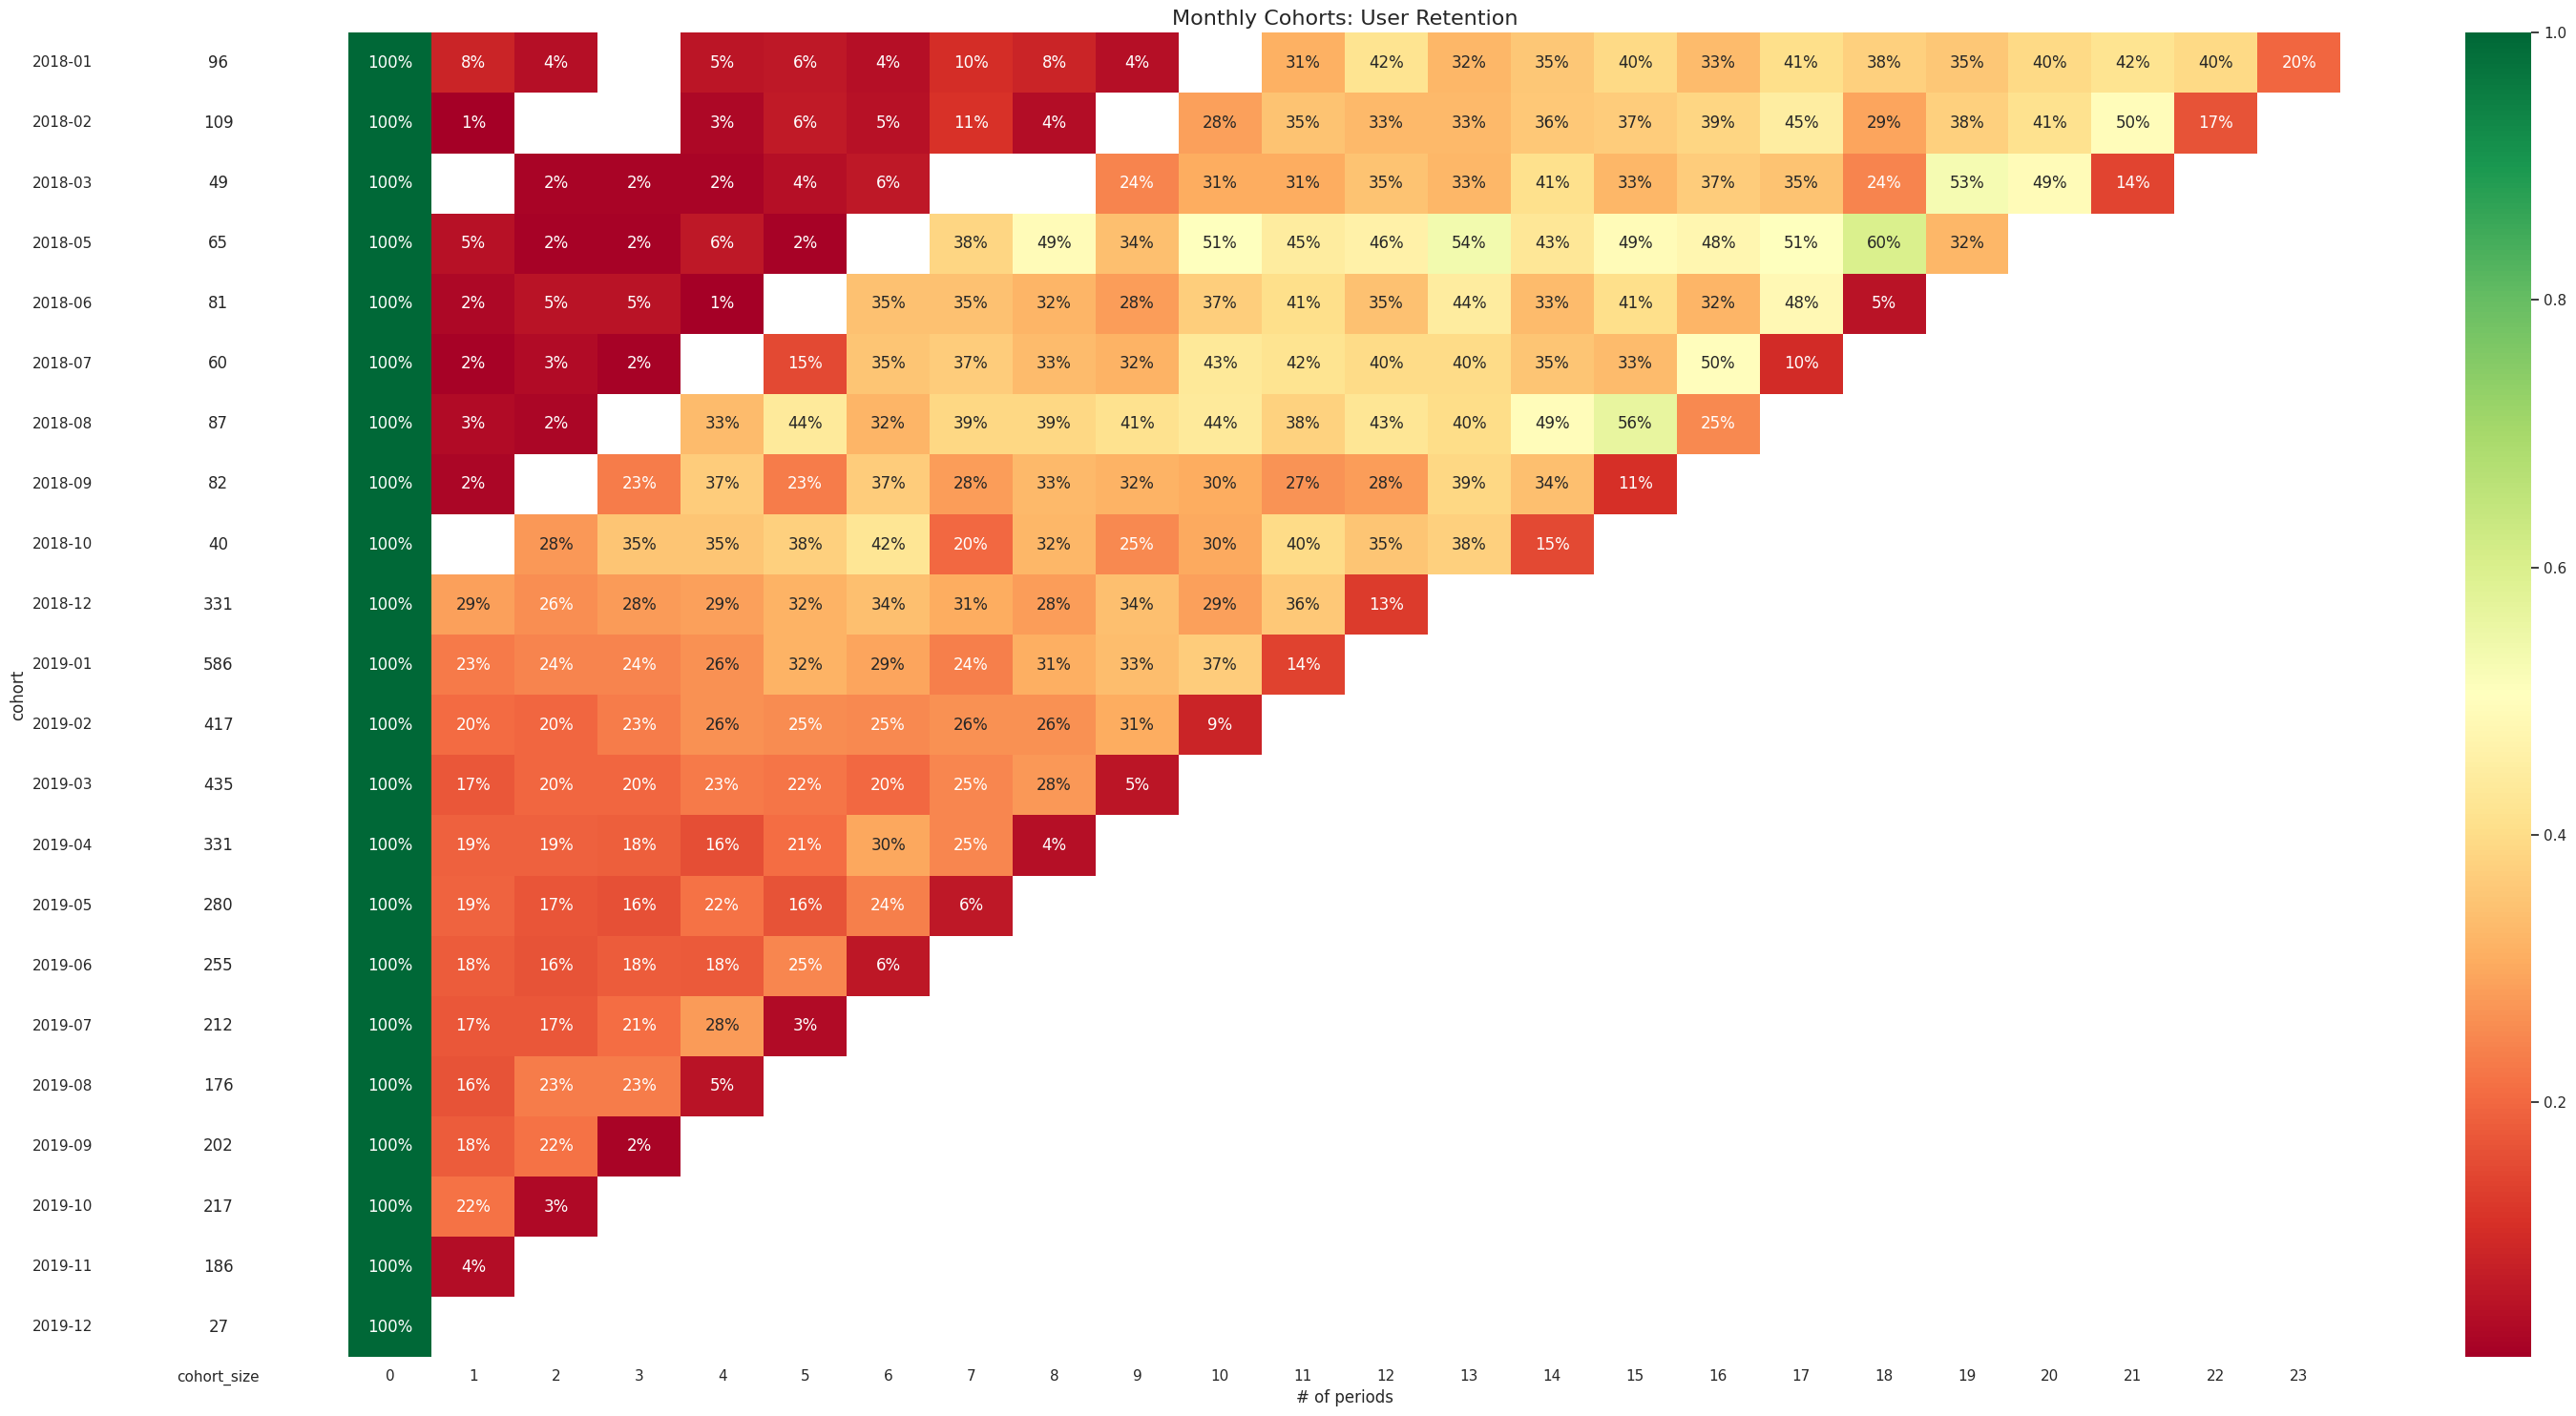

In [ ]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(30, 15), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # retention matrix
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()

it might be the reasons that some of them were because of the cancelled order because of lack of stocks and APril and November . those two months  whole transactions are missing. which could be lack of back up warehouse.